In [4]:
import os
os.chdir('/gpfs/summit/scratch/dasr8731/needfinder/')

In [5]:
import os
import glob
import json
import string

import pandas as pd
import numpy as np

In [12]:
eval_dirpath = 'data/eval_set'
eval_results_path = 'data/*autoeval_results.csv' 


### Reading Groundtruth

In [6]:
groundtruth = []
files = glob.glob(os.path.join(eval_dirpath , '*.json'))
for f in files : 
    groundtruth.append(json.load(open(f)))

### Creating maps between quotes - title/section and vice versa

In [7]:
ids2quotes = {}
quotes2ids = {}

for res in groundtruth :
    title = res['title']
    ids2quotes[title] = {}

    for section in res['sections'] : 
        section_header = section['section_header']
        ids2quotes[title][section_header] = section['quotes']

        for quote in section['quotes'] : 

            quotes2ids[quote] = {'title' : title , 
                            'section' : section_header, 
                            }

                    
sentences = list(quotes2ids.keys())

### Function definitions 

In [8]:
def get_adjacent_quotes(query, section_quotes) : 
    
    query_index = section_quotes.index(query)
    is_last_quote = False
    is_first_quote = False
    
    if query_index == len(section_quotes)-1 : 
        is_last_quote = True
        
    if query_index == 0 : 
        is_first_quote = True
        

    if is_last_quote and is_first_quote : 
        return [None , None]
    
    elif is_last_quote and not is_first_quote:
        return [section_quotes[query_index-1] , None]
    
    elif is_first_quote and not is_last_quote : 
        return [None, section_quotes[query_index+1] ]
    
    else :
        return [section_quotes[query_index-1], section_quotes[query_index+1] ]

In [9]:
def check_relation(query, target) : 
    
    query_paper_title = quotes2ids[query]['title']
    query_paper_section = quotes2ids[query]['section']
    
    title_quotes = []
    for section_header , quotes in ids2quotes[query_paper_title].items() : 
        title_quotes.extend(quotes)
        
    section_quotes = ids2quotes[query_paper_title][query_paper_section]
    
    adjacent_quotes = get_adjacent_quotes(query, section_quotes)
    
    if target in adjacent_quotes :
        return 'adjacent'
    
    elif target==query : 
        return 'same_quote'
    
    elif target in section_quotes : 
        return 'same_section'
    
    elif target in title_quotes : 
        return 'same_paper' 
    
    else : 
        return 'different_paper'
        

### reading results

In [13]:
glob.glob(eval_results_path)

['data/multi-qa-mpnet-base-dot-v1_autoeval_results.csv',
 'data/multi-qa-distilbert-cos-v1_autoeval_results.csv',
 'data/all-mpnet-base-v2_autoeval_results.csv',
 'data/paraphrase-MiniLM-L3-v2_autoeval_results.csv',
 'data/autoeval_results.csv']

paraphrase-MiniLM-L3-v2
count    23409.000000
mean         0.127493
std          0.142256
min         -0.255449
25%          0.039967
50%          0.113901
75%          0.194611
max          1.000000
Name: sim, dtype: float64


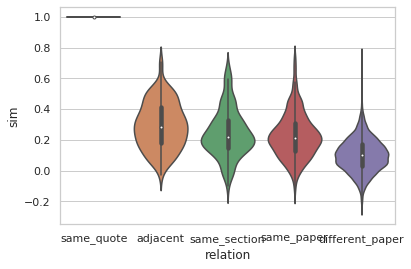

In [24]:
eval_result = 'data/paraphrase-MiniLM-L3-v2_autoeval_results.csv'



model_name = os.path.basename(eval_result).replace('_autoeval_results.csv' , '')
print(model_name)
results_df  = pd.read_csv(eval_result, index_col=0)
# print(results_df.head())


# compiling relations and similarity 

relation_dict = {'query' : [] ,
                'target' : [] , 
                'sim' : [] , 
                'relation' : []
                }

for query, row in results_df.iterrows() : 

    for target , sim in row.items() : 

        relation_dict['query'].append(query)
        relation_dict['target'].append(target)
        relation_dict['sim'].append(sim)
        relation_dict['relation'].append(check_relation(query, target))

relation_df = pd.DataFrame(relation_dict)

# print(relation_df.head())
print(relation_df['sim'].describe())

# plotting violin plot

import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.violinplot(y=relation_df["sim"], x=relation_df["relation"], scale='width')
ax.figure.savefig('data/{}_violin_plot.png'.format(model_name))
